## CS439: Final Project
### Detecting Alzheimer's Disease from Handwriting
#### Authors: Rija Khan (rk1047), Mariam Khan (mk2199), Maria Iqbal (mi327)

**Step 1**: Need to load the dataset into our program.

Link to the dataset: https://www.kaggle.com/datasets/taeefnajib/handwriting-data-to-detect-alzheimers-disease

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import re
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import seaborn as sns 
import matplotlib.pyplot as plt


In [2]:
# Load dataset
og_df = pd.read_csv("data.csv")
og_df.head()

,ID,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,...,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class
0,id_1,5160,0.000013,120.804174,86.853334,957,6601,0.361800,0.217459,103.828754,...,0.141434,0.024471,5.596487,3.184589,71,40120,1749.278166,296102.7676,144605,P
1,id_2,51980,0.000016,115.318238,83.448681,1694,6998,0.272513,0.144880,99.383459,...,0.049663,0.018368,1.665973,0.950249,129,126700,1504.768272,278744.2850,298640,P
2,id_3,2600,0.000010,229.933997,172.761858,2333,5802,0.387020,0.181342,201.347928,...,0.178194,0.017174,4.000781,2.392521,74,45480,1431.443492,144411.7055,79025,P
3,id_4,2130,0.000010,369.403342,183.193104,1756,8159,0.556879,0.164502,276.298223,...,0.113905,0.019860,4.206746,1.613522,123,67945,1465.843329,230184.7154,181220,P
4,id_5,2310,0.000007,257.997131,111.275889,987,4732,0.266077,0.145104,184.636510,...,0.121782,0.020872,3.319036,1.680629,92,37285,1841.702561,158290.0255,72575,P


In [3]:
# Extracting shape, datatypes, and information just for reference
og_df.shape

(174, 452)

In [4]:
og_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Columns: 452 entries, ID to class
dtypes: float64(300), int64(150), object(2)
memory usage: 614.6+ KB


In [5]:
og_df.dtypes

ID                  object
air_time1            int64
disp_index1        float64
gmrt_in_air1       float64
gmrt_on_paper1     float64
                    ...   
paper_time25         int64
pressure_mean25    float64
pressure_var25     float64
total_time25         int64
class               object
Length: 452, dtype: object

In [6]:
# Check for any missing values
og_df.isnull()

,ID,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,...,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
170,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
171,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
172,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


**Step 2**: Get columns needed for detection models.
For our purposes, we are planning to go with trials 1, 2, and 6 since they are different writing tests (M,G,C) that patients were made to do.
We will be using all 18 attributes/features for all 25 trials for the model predictions.
We will also need the class column to classify each person as either a patient (P) or healthy (H).

In [7]:
og_df['class'] = og_df['class'].map({'P': 0, 'H': 1})

# Keep features ending in trial 1, 2, or 6 
def is_trial_1_2_6(col_name):
    match = re.search(r'(\d+)$', col_name)
    return match and match.group(1) in {'1', '2', '6'}

trial_features = [col for col in og_df.columns if is_trial_1_2_6(col) and col != 'class']

# Prepare data
X = og_df[trial_features].select_dtypes(include=['number']).fillna(0)
y = og_df['class']

# Select top 20 features
selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

print("Top 20 features from trials 1, 2, and 6 ONLY:\n", selected_features)

# From the output, we can see that:
# air_time, msp, pressure_mean  <- features found useful for 1, 2 and 6
# disp_index, paper_time, total_time <- features found in common for 2, 6

Top 20 features from trials 1, 2, and 6 ONLY:
 Index(['air_time1', 'gmrt_on_paper1', 'mean_speed_on_paper1', 'pressure_mean1',
       'air_time2', 'disp_index2', 'gmrt_in_air2', 'max_x_extension2',
       'mean_speed_on_paper2', 'num_of_pendown2', 'paper_time2',
       'pressure_mean2', 'total_time2', 'air_time6', 'disp_index6',
       'mean_speed_on_paper6', 'num_of_pendown6', 'paper_time6',
       'pressure_mean6', 'total_time6'],
      dtype='object')


In [8]:
# Class(label: patient (0) or healthy (1))

trial1 = pd.DataFrame(og_df[['air_time1','disp_index1','gmrt_in_air1','gmrt_on_paper1','max_x_extension1','max_y_extension1',                             'mean_acc_in_air1','mean_acc_on_paper1','mean_gmrt1','mean_jerk_in_air1','mean_jerk_on_paper1',
                             'mean_speed_in_air1','mean_speed_on_paper1','num_of_pendown1','paper_time1','pressure_mean1',
                             'pressure_var1','total_time1', 'class']])

trial2 = pd.DataFrame(og_df[['air_time2','disp_index2','gmrt_in_air2','gmrt_on_paper2','max_x_extension2','max_y_extension2',                             'mean_acc_in_air1','mean_acc_on_paper1','mean_gmrt1','mean_jerk_in_air1','mean_jerk_on_paper1',
                             'mean_speed_in_air2','mean_speed_on_paper2','num_of_pendown2','paper_time2','pressure_mean2',
                             'pressure_var2','total_time2', 'class']])


trial6 = pd.DataFrame(og_df[['air_time6','disp_index6','gmrt_in_air6','gmrt_on_paper6','max_x_extension6','max_y_extension6',                             'mean_acc_in_air1','mean_acc_on_paper1','mean_gmrt1','mean_jerk_in_air1','mean_jerk_on_paper1',
                             'mean_speed_in_air6','mean_speed_on_paper6','num_of_pendown6','paper_time6','pressure_mean6',
                             'pressure_var6','total_time6', 'class']])


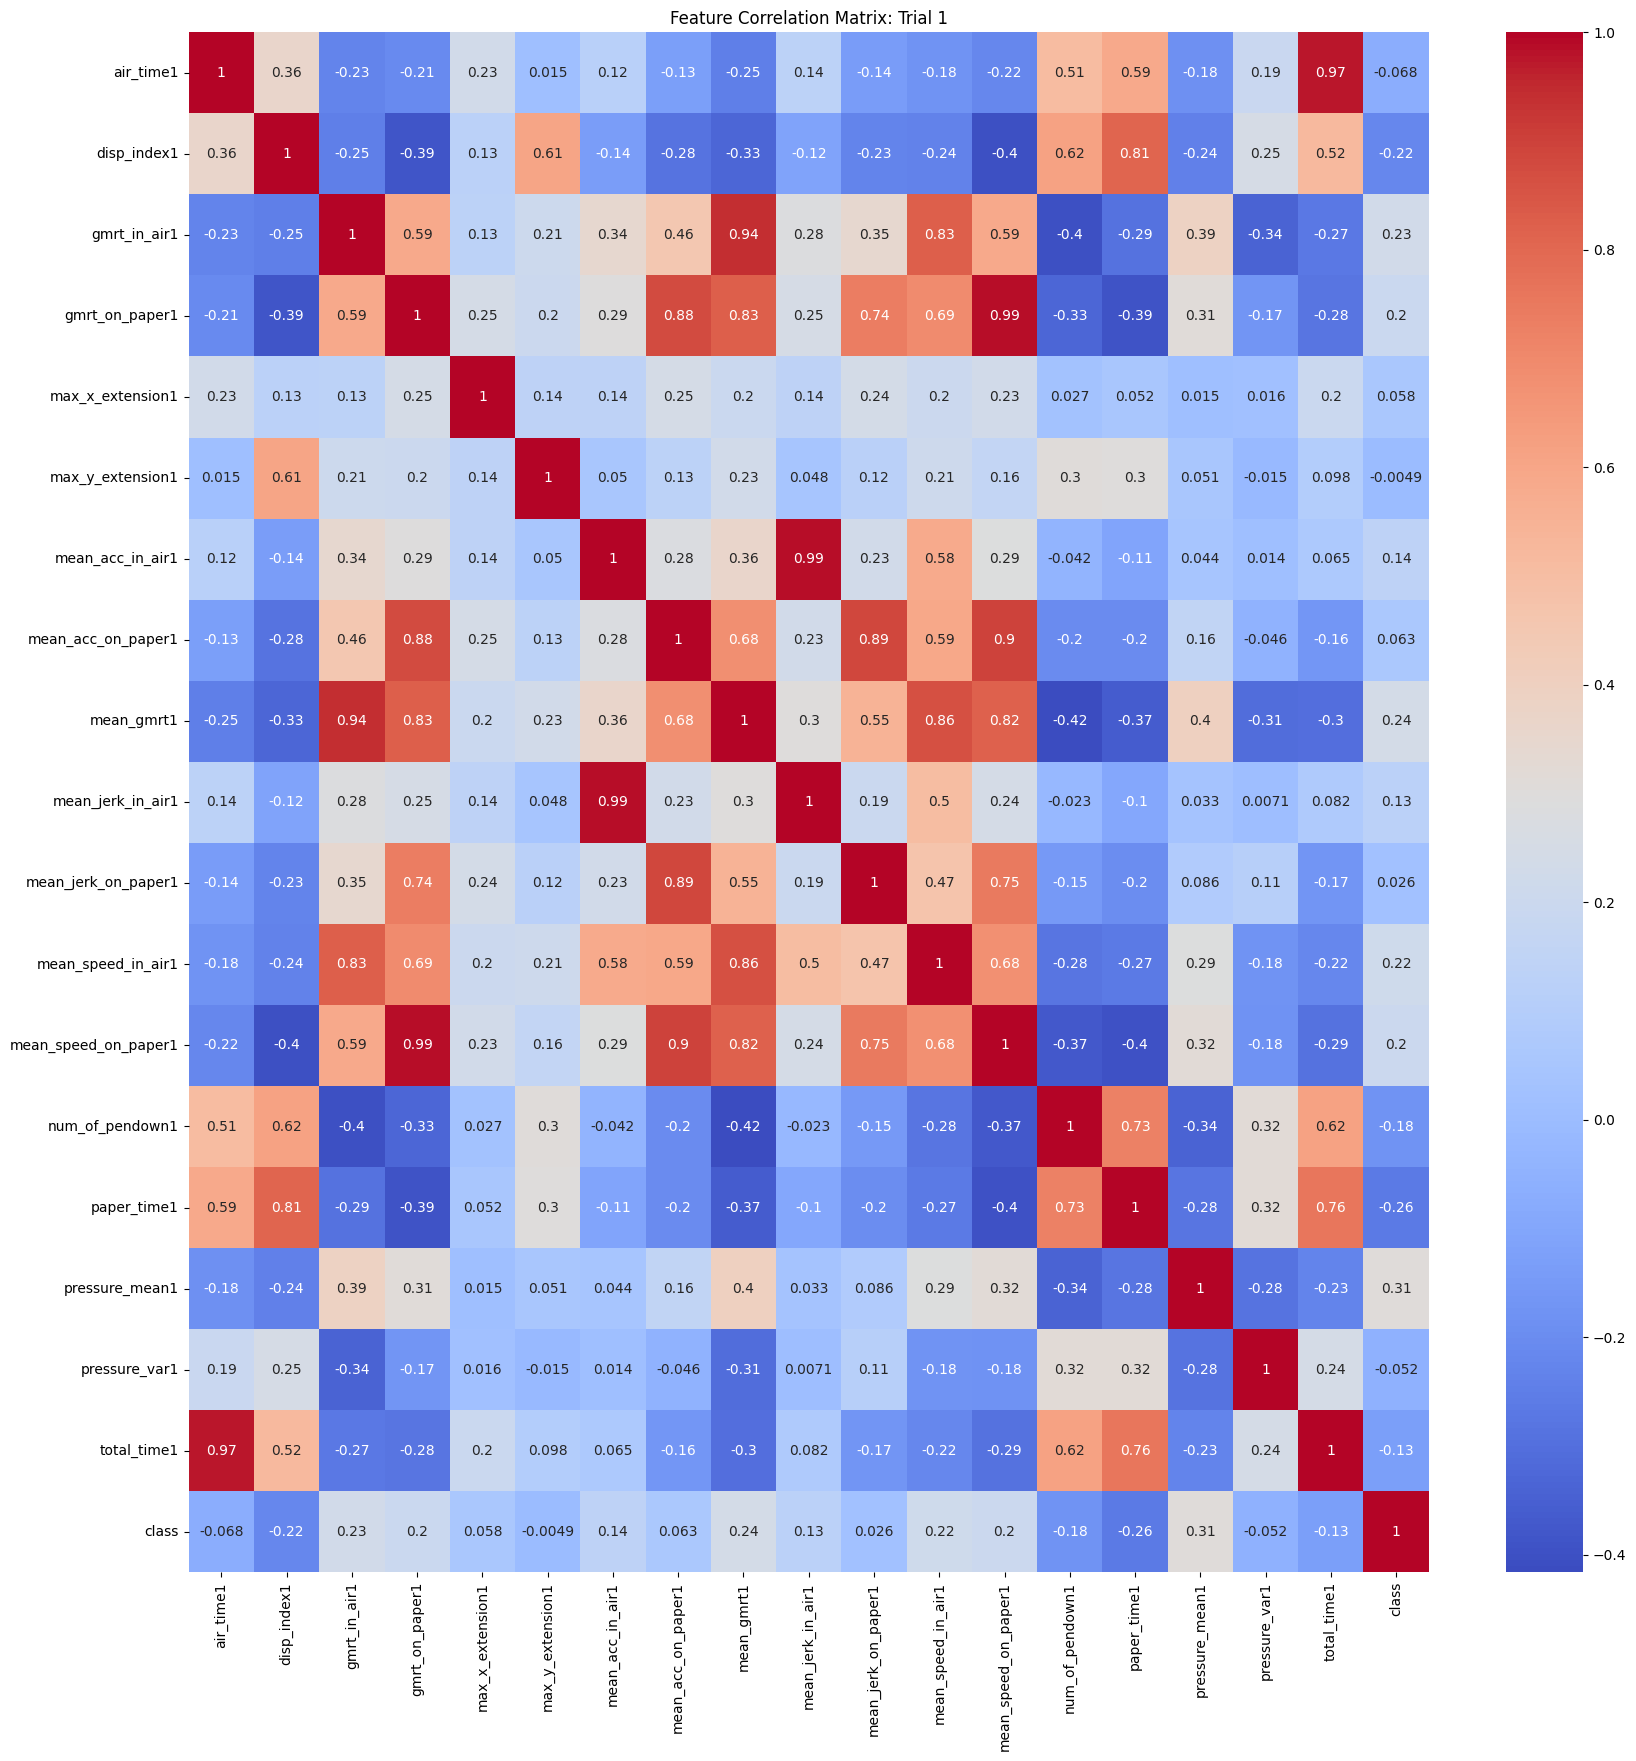

In [9]:
corr_matrix = trial1.corr() 
plt.figure(figsize=(20, 20)) 

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm') 
plt.title("Feature Correlation Matrix: Trial 1")

plt.show()

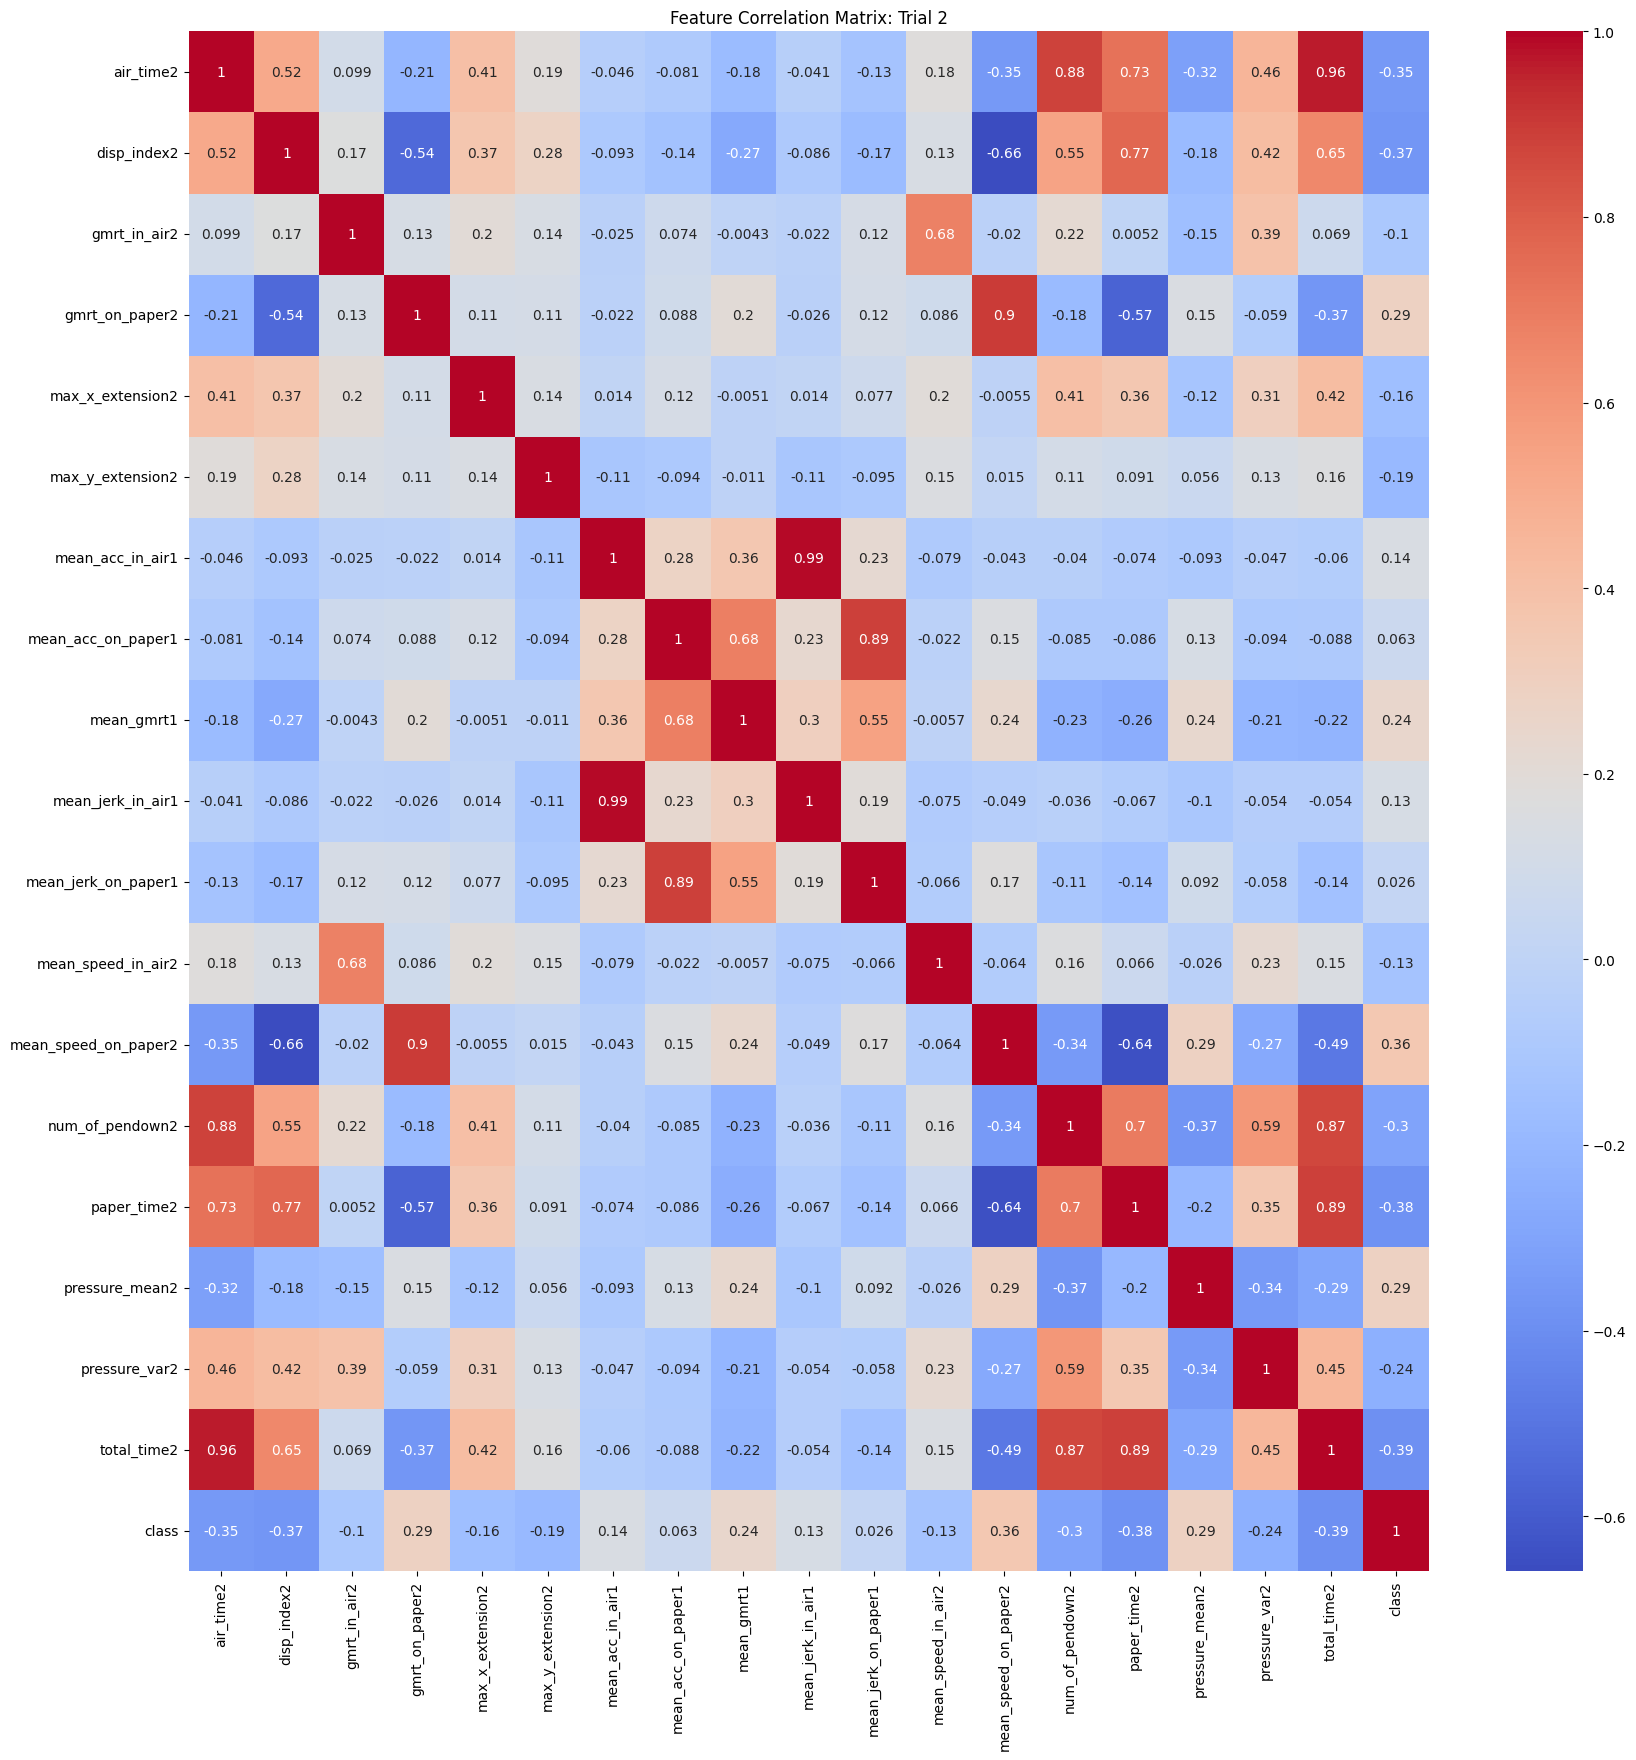

In [10]:
corr_matrix = trial2.corr() 
plt.figure(figsize=(20, 20)) 

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm') 
plt.title("Feature Correlation Matrix: Trial 2")

plt.show()

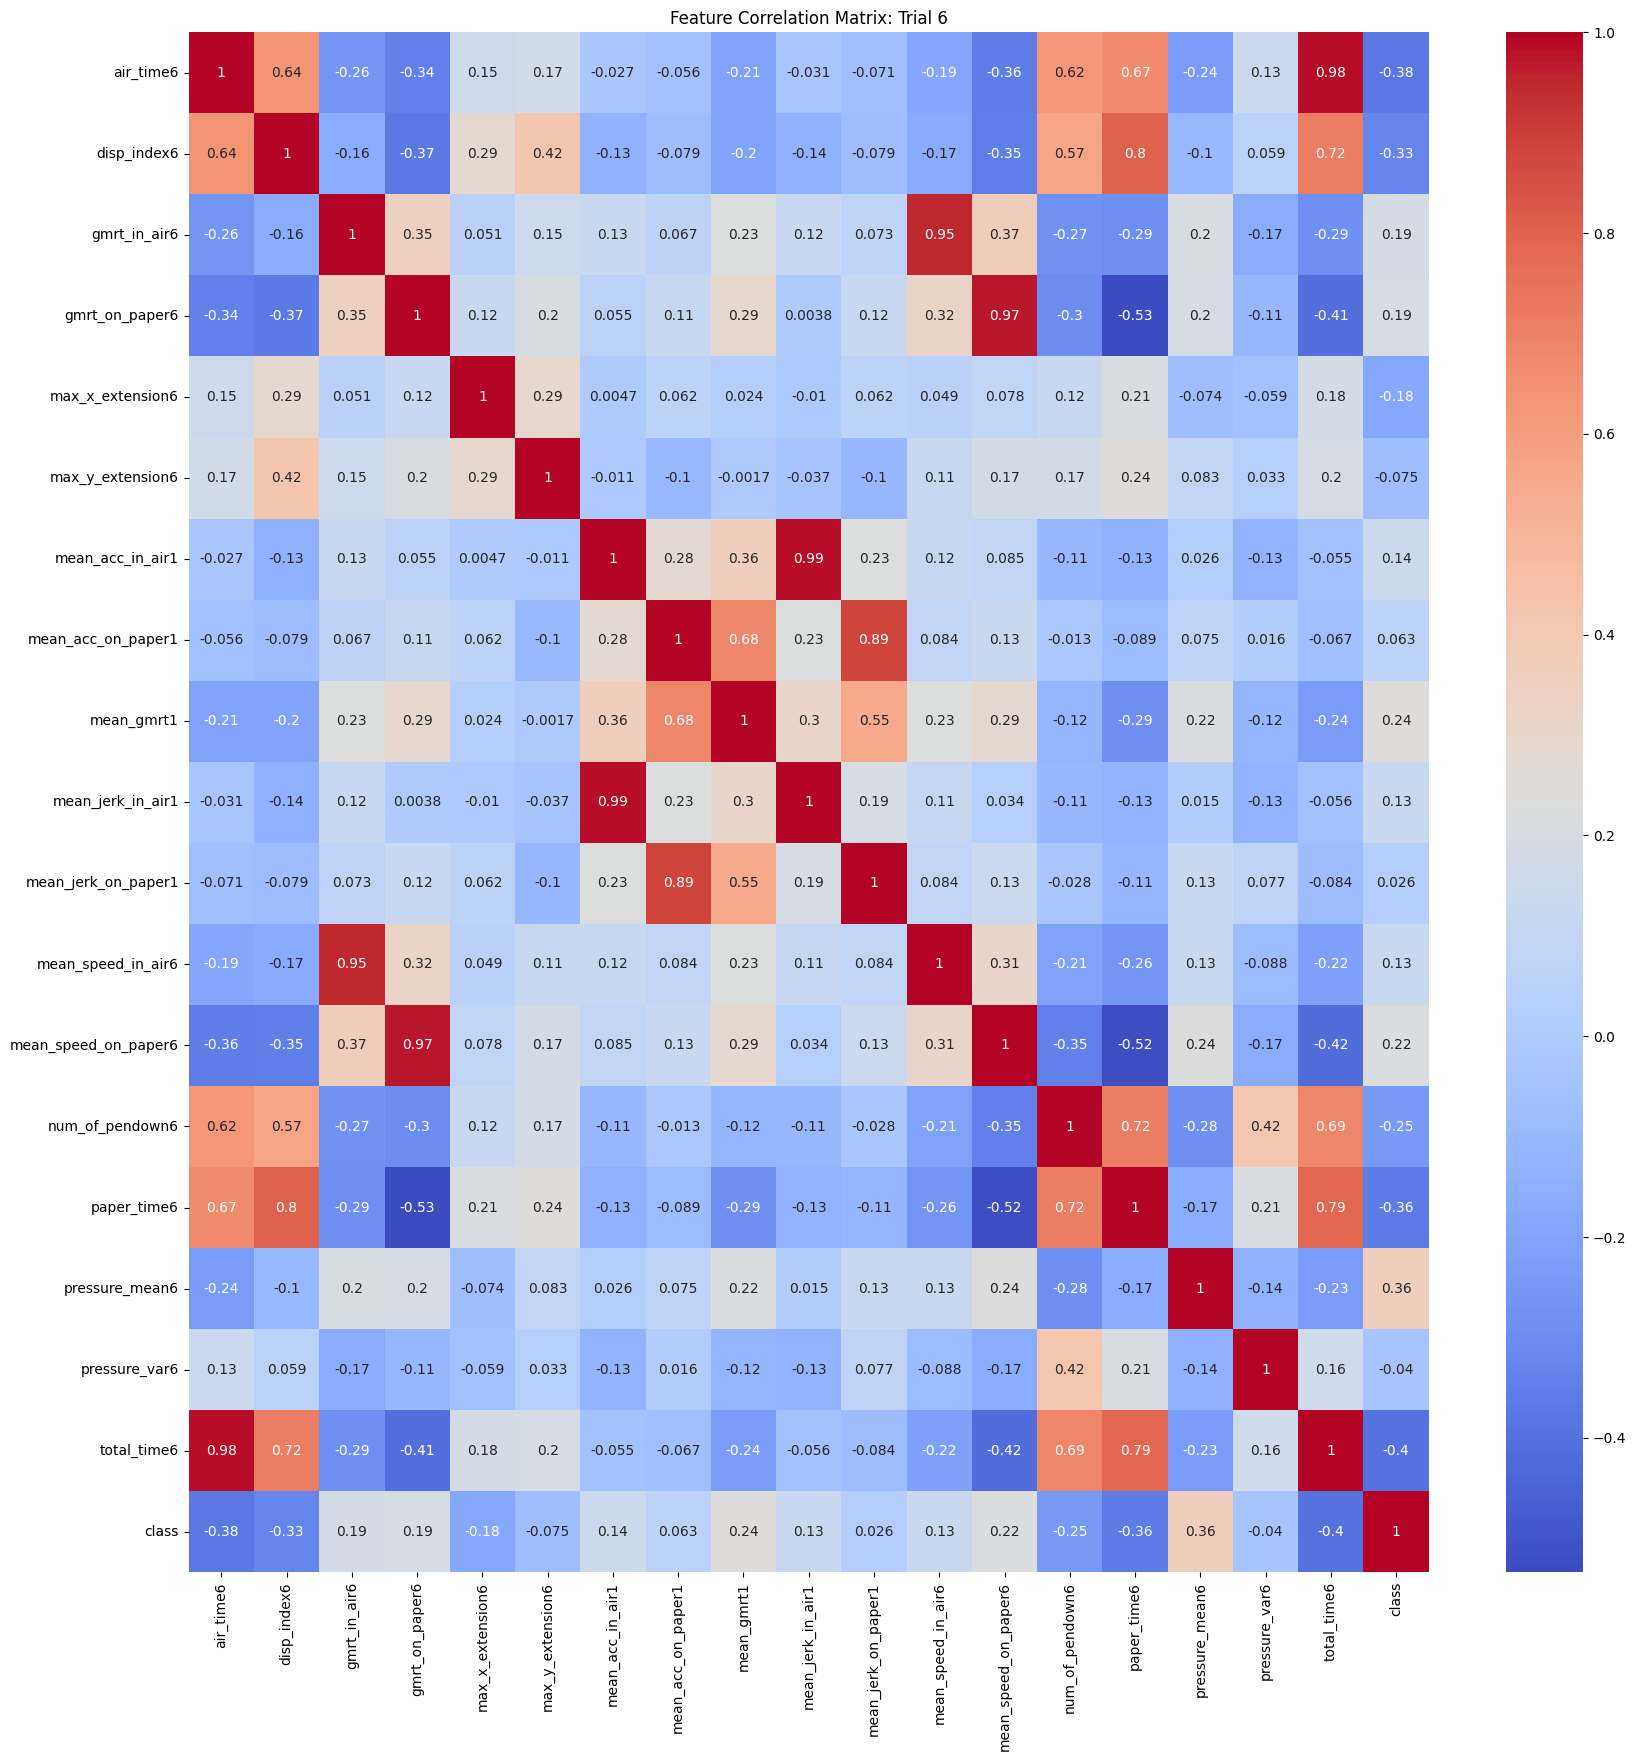

In [11]:
corr_matrix = trial6.corr() 
plt.figure(figsize=(20, 20)) 

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm') 
plt.title("Feature Correlation Matrix: Trial 6")

plt.show()

**Step 3**: Modeling

1. Gaussian Naive Bayes
2. Random forest
3. Support Vector Machine (SVM)
4. Logistic Regression

#### **GAUSSIAN NAIVE BAYES**

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

def gaussianNBModel(trial, output=False) :
    # Split data into features & target
    X = trial.drop('class', axis=1)
    y = trial['class']

    # Make training & est sets - 30% of data goes to test set, 70% to training - can change random_state to any # - 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    # Train a NB Classifier (assuming it follows a normal distribution)
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)

    # Make prediction
    y_pred = nb_model.predict(X_test)
    
    
    # analysis
    a = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)

    if output == True: 
        print("Accuracy:", a)
        print("Classification Report:\n", cr)
        print("Confusion Matrix:\n", cm)

    return a, cr, nb_model

GNB_trial1_accuracy, GNB_trial1_CR, nb1 = gaussianNBModel(trial1)
GNB_trial2_accuracy, GNB_trial2_CR, nb2 = gaussianNBModel(trial2)
GNB_trial6_accuracy, GNB_trial6_CR, nb6 = gaussianNBModel(trial6)

- The model is shown to correctly predict whether a patient is healthy or not approximately 66% of the time. 
- Looking at the confusion matrix, there were 12 TP (true positives - 12 people were healthy and were correctly classified), 15 FN (false negatives - 15 healthy people were predicted as patients), 3 FP (false positives - 3 patients were misclassified as healthy), and 23 TN (true negatives - 23 patients got classified correctly).
- Looking at the classification report:
    - Precision: Of all the times the model made a prediction, 80% of predicted healthy people were actually healthy, 61% of predicted patients were actually patient
    - Recall: Of all the actual H & P examples, the model found 44% of actual healthy people correctly, and 88% of actual patients correctly
    - f1-score: For healthy people (class 0), the f-1 score is 57%, while for patients (class 1), the f-1 score is 72%. Falling between the 0.5 - 0.8 range suggests that the model is adequate in terms of making predictions. This average score means this model may not be the best fit for this scenario.

#### **RANDOM FOREST**

In [13]:
from sklearn.ensemble import RandomForestClassifier
def RandomForestModel(trial, output=False) :
    # Split data into features & target
    X = trial.drop('class', axis=1)
    y = trial['class']

    # Make training & test sets - 30% of data goes to test set, 70% to training - can change random_state to any # - 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Train a RF Classifier
    rf_model = RandomForestClassifier(max_depth=10, n_estimators=300, bootstrap=False, min_samples_split=2, min_samples_leaf=1, class_weight='balanced')
    rf_model.fit(X_train, y_train)

    # Make prediction
    y_pred = rf_model.predict(X_test)

    # Metrics
    a = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)

    if output == True: 
        print("Accuracy:", a)
        print("Classification Report:\n", cr)
        print("Confusion Matrix:\n", cm)

    return a, cr, rf_model

RF_trial1_accuracy, RF_trial1_CR, rf1 = RandomForestModel(trial1)
RF_trial2_accuracy, RF_trial2_CR, rf2 = RandomForestModel(trial2)
RF_trial6_accuracy, RF_trial6_CR, rf6 = RandomForestModel(trial6)

#### **SUPPORT VECTOR MACHINE**

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

def SupportVectorMachines(trial, output=False) :
    # Split data into features & target
    X = trial.drop('class', axis=1)
    y = trial['class']

    # Make training & test sets - 30% of data goes to test set, 70% to training - can change random_state to any # - 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Scale our data 
    sc = StandardScaler().fit(X_train)
    Xtr, Xte = sc.transform(X_train), sc.transform(X_test)

    # Train a SVM Classifier 
    svm_model = SVC(kernel='linear', probability=True, random_state=42, class_weight='balanced')
    svm_model.fit(Xtr, y_train)
    y_pred = svm_model.predict(X_test)

    # Make prediction
    y_pred = svm_model.predict(Xte)

    # Metrics
    a = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)

    if output == True: 
        print("Accuracy:", a)
        print("Classification Report:\n", cr)
        print("Confusion Matrix:\n", cm)

    return a, cr, svm_model

SVM_trial1_accuracy, SVM_trial1_CR, svm1 = SupportVectorMachines(trial1)
SVM_trial2_accuracy, SVM_trial2_CR, svm2 = SupportVectorMachines(trial2)
SVM_trial6_accuracy, SVM_trial6_CR, svm6 = SupportVectorMachines(trial6)

#### **LOGISTIC REGRESSION**

In [15]:
from sklearn.linear_model     import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

def logistic_regression(trial, output=False) :
    # Split data into features & target
    X = trial.drop('class', axis=1)
    y = trial['class']

    # Make training & test sets - 30% of data goes to test set, 70% to training - can change random_state to any # - 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Scale our data 
    sc = StandardScaler().fit(X_train)
    Xtr, Xte = sc.transform(X_train), sc.transform(X_test)

    # Train a LR Classifier 
    lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    lr_model.fit(Xtr, y_train)
    y_pred = lr_model.predict(Xte)

    # Make prediction
    y_pred = lr_model.predict(Xte)

    # Metrics
    a = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)

    if output == True: 
        print("Accuracy:", a)
        print("Classification Report:\n", cr)
        print("Confusion Matrix:\n", cm)

    return a, cr, lr_model

LR_trial1_accuracy, LR_trial1_CR, lr1 = logistic_regression(trial1)
LR_trial2_accuracy, LR_trial2_CR, lr2 = logistic_regression(trial2)
LR_trial6_accuracy, LR_trial6_CR, lr6 = logistic_regression(trial6)

**Step 4**: Comparative Analysis of trials 1, 2, and 6

In [16]:
# Analyzing all of our models accuracy 
GNB_average = (GNB_trial1_accuracy + GNB_trial2_accuracy + GNB_trial6_accuracy)/3
RF_average = (RF_trial1_accuracy + RF_trial2_accuracy + RF_trial6_accuracy)/3
SVM_average = (SVM_trial1_accuracy + SVM_trial2_accuracy + SVM_trial6_accuracy)/3
LR_average = (LR_trial1_accuracy + LR_trial2_accuracy + LR_trial6_accuracy)/3
print(f'GNB Average: {GNB_average:.2%}')
print(f'RF Average: {RF_average:.2%}')
print(f'SVM Average: {SVM_average:.2%}')
print(f'LR Average: {LR_average:.2%}')


GNB Average: 70.44%
RF Average: 69.81%
SVM Average: 66.67%
LR Average: 72.96%


#### **ACCURACY OF ALL TRIALS, ALL FEAUTURES**

**Step 5**: Comparative Analysis of all 25 trials

Now we will formally run all 25 trials through all 4 of our models. We will use the results as a bench mark to understand the perfect number of features needed to gain maximum accuracy. 

In [17]:

def analyze(trials, model):
    mean_accuracy = 0
    total_accuracy = []

    # Accuracy for all 25 trials  
    for i, trial in enumerate(trials, start=1): 
        if model == 'GNB':
            trial_accuracy, trial_CR, _ = gaussianNBModel(trial)
            total_accuracy.append(trial_accuracy)
            mean_accuracy += trial_accuracy
        elif model == 'RF':
            trial_accuracy, trial_CR, _ = RandomForestModel(trial)
            total_accuracy.append(trial_accuracy)
            mean_accuracy += trial_accuracy
        elif model == 'SVM':
            trial_accuracy, trial_CR, _ = SupportVectorMachines(trial)
            total_accuracy.append(trial_accuracy)
            mean_accuracy += trial_accuracy
        elif model == 'LR':
            trial_accuracy, trial_CR, _ = logistic_regression(trial)
            total_accuracy.append(trial_accuracy)
            mean_accuracy += trial_accuracy
    mean_accuracy/=25
    print(f'{model} Accuracy: {mean_accuracy:.2%}')

    # Finding the top 3 trials for best accuracy 
    top3 = total_accuracy.copy()

    max1 = max(enumerate(top3), key=lambda x: x[1])
    top3[max1[0]] = float('-inf')  

    max2 = max(enumerate(top3), key=lambda x: x[1])
    top3[max2[0]] = float('-inf') 

    max3 = max(enumerate(top3), key=lambda x: x[1])
    top3[max3[0]] = float('-inf')  

    a = (max1[1] + max2[1] + max3[1]) / 3
    print(f'Accuracy of top 3 trials: {a:.2%}')
    print(f"Top 3 trials: {max1[0]}, {max2[0]}, {max3[0]}")

In [18]:
# extracting all 25 trials and all features 
trials = []
for i in range(1,25):
    trial = pd.DataFrame(og_df[[f'air_time{i}', f'disp_index{i}', f'gmrt_in_air{i}',
                                f'gmrt_on_paper{i}', f'max_x_extension{i}',f'max_y_extension{i}',
                                f'mean_acc_in_air{i}',f'mean_acc_on_paper{i}',f'mean_gmrt{i}',
                                f'mean_jerk_in_air{i}',f'mean_jerk_on_paper{i}', 
                                f'mean_speed_in_air{i}',f'mean_speed_on_paper{i}',
                                f'num_of_pendown{i}', f'paper_time{i}',f'pressure_mean{i}',
                                f'pressure_var{i}', f'total_time{i}', 'class']])
    trials.append(trial)

In [19]:
# Gaussian Naive Bayes
analyze(trials, 'GNB')
print('\n')
analyze(trials, 'RF')
print('\n')
analyze(trials, 'SVM')
print('\n')
analyze(trials, 'LR')

GNB Accuracy: 66.42%
Accuracy of top 3 trials: 83.65%
Top 3 trials: 16, 11, 15


RF Accuracy: 70.42%
Accuracy of top 3 trials: 84.91%
Top 3 trials: 15, 18, 19


SVM Accuracy: 69.28%
Accuracy of top 3 trials: 79.25%
Top 3 trials: 5, 6, 11


LR Accuracy: 70.11%
Accuracy of top 3 trials: 79.87%
Top 3 trials: 5, 6, 11


#### **RE-EVALUATING WHICH FEATURES TO USE**

Question: How do we know which features will result in the best accuracy? We can make educated guesses about what affects a model, but there is no way to tell unless we test out independent features or all 25 feautures. 

Let's start with testing out independent features. If naive bayes works under the assumption that all features are independent, what if we use only independent features?

In [20]:
# independent features 
indep_feats = [
  'disp_index1',
  'gmrt_in_air1','gmrt_on_paper1','mean_gmrt1',
  'max_x_extension1','max_y_extension1',
  'num_of_pendown1',
  'pressure_mean1','pressure_var1',
  'class'
]
df_indep = og_df[indep_feats]
GNB_accuracy, GNB_CR, _ = gaussianNBModel(df_indep)
print(f"Independent Trial1: {GNB_accuracy}")



Independent Trial1: 0.5283018867924528


As we can see, our independent trial did worse than our previous trial with all features. We went from 66% to 53%. This may be due to a few causes. One of them being, independence in our data caused our model to become too simple. 

#### **MEAN ACCURACY OF EACH FEATURE**
understand how each feature impacts the overall accuracy rate of GNB, RF, SVM, LR 

In [21]:
#GNB 
# For each feature in the data set, run Naive Bayes for all 25 trials to find the mean accuracy of each feature 
feature = [f'air_time{i}', f'disp_index{i}', f'gmrt_in_air{i}',
                                f'gmrt_on_paper{i}', f'max_x_extension{i}',f'max_y_extension{i}',
                                f'mean_acc_in_air{i}',f'mean_acc_on_paper{i}',f'mean_gmrt{i}',
                                f'mean_jerk_in_air{i}',f'mean_jerk_on_paper{i}', 
                                f'mean_speed_in_air{i}',f'mean_speed_on_paper{i}',
                                f'num_of_pendown{i}', f'paper_time{i}',f'pressure_mean{i}',
                                f'pressure_var{i}', f'total_time{i}']
data = {}

# goes through each feaure and saves a dictionary with feat, accuracy pairs 
for feat in feature:
    trials = []
    for i in range(1,25):
        trial = pd.DataFrame(og_df[[feat,'class']])
        trials.append(trial)

    mean_accuracy = 0
    total_accuracy = []

    # accuracy for all 25 trials  
    for i, trial in enumerate(trials, start=1): 
        trial_accuracy, trial_CR, _ = gaussianNBModel(trial)
        total_accuracy.append(trial_accuracy)
        mean_accuracy += trial_accuracy
    mean_accuracy/=25
    data[feat] = mean_accuracy
    
#top 5 features 
from collections import Counter
 
n = 10  # number of top values
 
counter = Counter(data)
result = dict(counter.most_common(n))
 
print("The top N value pairs are ", result)


The top N value pairs are  {'air_time24': 0.6158490566037738, 'total_time24': 0.6158490566037738, 'mean_gmrt24': 0.5977358490566034, 'mean_speed_in_air24': 0.5796226415094339, 'gmrt_on_paper24': 0.5433962264150942, 'disp_index24': 0.5252830188679245, 'mean_acc_in_air24': 0.5252830188679245, 'mean_jerk_in_air24': 0.5252830188679245, 'num_of_pendown24': 0.5252830188679245, 'paper_time24': 0.507169811320755}


In [22]:
print(data)
trials = []
for i in range(1,25):
    trial = pd.DataFrame(og_df[[f'air_time{i}', f'total_time{i}', f'mean_gmrt{i}', f'mean_speed_in_air{i}', f'gmrt_on_paper{i}', 
                                f'disp_index{i}', f'mean_acc_in_air{i}', f'mean_jerk_in_air{i}', f'num_of_pendown{i}', f'paper_time{i}', 
                                'class']])                       
    trials.append(trial)

{'air_time24': 0.6158490566037738, 'disp_index24': 0.5252830188679245, 'gmrt_in_air24': 0.48905660377358473, 'gmrt_on_paper24': 0.5433962264150942, 'max_x_extension24': 0.48905660377358473, 'max_y_extension24': 0.4709433962264153, 'mean_acc_in_air24': 0.5252830188679245, 'mean_acc_on_paper24': 0.4166037735849057, 'mean_gmrt24': 0.5977358490566034, 'mean_jerk_in_air24': 0.5252830188679245, 'mean_jerk_on_paper24': 0.4709433962264153, 'mean_speed_in_air24': 0.5796226415094339, 'mean_speed_on_paper24': 0.4166037735849057, 'num_of_pendown24': 0.5252830188679245, 'paper_time24': 0.507169811320755, 'pressure_mean24': 0.507169811320755, 'pressure_var24': 0.4166037735849057, 'total_time24': 0.6158490566037738}


In [23]:
analyze(trials, 'GNB')

GNB Accuracy: 64.23%
Accuracy of top 3 trials: 79.87%
Top 3 trials: 16, 9, 11


In [33]:
print(data)
trials = []
for i in range(1,25):
    trial = pd.DataFrame(og_df[[f'air_time{i}', f'total_time{i}', f'mean_gmrt{i}', f'mean_speed_in_air{i}', f'gmrt_on_paper{i}', 'class']])                       
    trials.append(trial)

{'air_time24': 0.6520754716981135, 'disp_index24': 0.5252830188679245, 'gmrt_in_air24': 0.5796226415094339, 'gmrt_on_paper24': 0.5252830188679245, 'max_x_extension24': 0.5252830188679245, 'max_y_extension24': 0.5977358490566034, 'mean_acc_in_air24': 0.5252830188679245, 'mean_acc_on_paper24': 0.5252830188679245, 'mean_gmrt24': 0.48905660377358473, 'mean_jerk_in_air24': 0.507169811320755, 'mean_jerk_on_paper24': 0.5796226415094339, 'mean_speed_in_air24': 0.5796226415094339, 'mean_speed_on_paper24': 0.507169811320755, 'num_of_pendown24': 0.5615094339622643, 'paper_time24': 0.6158490566037738, 'pressure_mean24': 0.5433962264150942, 'pressure_var24': 0.4709433962264153, 'total_time24': 0.6520754716981135}


In [34]:
analyze(trials, 'GNB')

GNB Accuracy: 62.57%
Accuracy of top 3 trials: 81.13%
Top 3 trials: 16, 9, 15


In [24]:
#RF 
# For each feature in the data set, run random forest for all 25 trials to find the mean accuracy of each feature 
feature = [f'air_time{i}', f'disp_index{i}', f'gmrt_in_air{i}',
                                f'gmrt_on_paper{i}', f'max_x_extension{i}',f'max_y_extension{i}',
                                f'mean_acc_in_air{i}',f'mean_acc_on_paper{i}',f'mean_gmrt{i}',
                                f'mean_jerk_in_air{i}',f'mean_jerk_on_paper{i}', 
                                f'mean_speed_in_air{i}',f'mean_speed_on_paper{i}',
                                f'num_of_pendown{i}', f'paper_time{i}',f'pressure_mean{i}',
                                f'pressure_var{i}', f'total_time{i}']
data = {}

# goes through each feaure and saves a dictionary with feat, accuracy pairs 
for feat in feature:
    trials = []
    for i in range(1,25):
        trial = pd.DataFrame(og_df[[feat,'class']])
        trials.append(trial)

    mean_accuracy = 0
    total_accuracy = []

    # accuracy for all 25 trials  
    for i, trial in enumerate(trials, start=1): 
        trial_accuracy, trial_CR, _ = RandomForestModel(trial)
        total_accuracy.append(trial_accuracy)
        mean_accuracy += trial_accuracy
    mean_accuracy/=25
    data[feat] = mean_accuracy
    
#top 5 features 
from collections import Counter
 
n = 10  # number of top values
 
counter = Counter(data)
result = dict(counter.most_common(n))
 
print("The top N value pairs are ", result)


The top N value pairs are  {'total_time24': 0.6701886792452829, 'air_time24': 0.6158490566037738, 'gmrt_in_air24': 0.5977358490566034, 'max_y_extension24': 0.5977358490566034, 'disp_index24': 0.5796226415094339, 'mean_acc_on_paper24': 0.5615094339622643, 'mean_jerk_in_air24': 0.5615094339622643, 'paper_time24': 0.5615094339622643, 'gmrt_on_paper24': 0.5433962264150942, 'pressure_mean24': 0.5433962264150942}


In [25]:
trials = []
for i in range(1,25):
    trial = pd.DataFrame(og_df[[f'total_time{i}', f'air_time{i}', f'gmrt_in_air{i}', f'mean_speed_in_air{i}', f'max_y_extension{i}', 
                                f'disp_index{i}', f'mean_acc_on_paper{i}', f'mean_jerk_in_air{i}', f'paper_time{i}', f'gmrt_on_paper{i}', 
                                'class']])                       
    trials.append(trial)

In [26]:
analyze(trials, 'RF')

RF Accuracy: 68.45%
Accuracy of top 3 trials: 79.87%
Top 3 trials: 19, 18, 14


In [35]:
trials = []
for i in range(1,25):
    trial = pd.DataFrame(og_df[[f'total_time{i}', f'air_time{i}', f'gmrt_in_air{i}', f'mean_speed_in_air{i}', f'max_y_extension{i}', 'class']])                       
    trials.append(trial)

In [36]:
analyze(trials, 'RF')

RF Accuracy: 66.11%
Accuracy of top 3 trials: 81.13%
Top 3 trials: 16, 18, 19


In [27]:
# SVM
# For each feature in the data set, run support vector machine for all 25 trials to find the mean accuracy of each feature 
feature = [f'air_time{i}', f'disp_index{i}', f'gmrt_in_air{i}',
                                f'gmrt_on_paper{i}', f'max_x_extension{i}',f'max_y_extension{i}',
                                f'mean_acc_in_air{i}',f'mean_acc_on_paper{i}',f'mean_gmrt{i}',
                                f'mean_jerk_in_air{i}',f'mean_jerk_on_paper{i}', 
                                f'mean_speed_in_air{i}',f'mean_speed_on_paper{i}',
                                f'num_of_pendown{i}', f'paper_time{i}',f'pressure_mean{i}',
                                f'pressure_var{i}', f'total_time{i}']
data = {}

# goes through each feaure and saves a dictionary with feat, accuracy pairs 
for feat in feature:
    trials = []
    for i in range(1,25):
        trial = pd.DataFrame(og_df[[feat,'class']])
        trials.append(trial)

    mean_accuracy = 0
    total_accuracy = []

    # accuracy for all 25 trials  
    for i, trial in enumerate(trials, start=1): 
        trial_accuracy, trial_CR, _ = SupportVectorMachines(trial)
        total_accuracy.append(trial_accuracy)
        mean_accuracy += trial_accuracy
    mean_accuracy/=25
    data[feat] = mean_accuracy
    
#top 5 features 
from collections import Counter
 
n = 10  # number of top values
 
counter = Counter(data)
result = dict(counter.most_common(n))
 
print("The top N value pairs are ", result)


The top N value pairs are  {'air_time24': 0.6339622641509431, 'mean_jerk_on_paper24': 0.6339622641509431, 'paper_time24': 0.6339622641509431, 'total_time24': 0.6339622641509431, 'max_y_extension24': 0.5615094339622643, 'disp_index24': 0.5433962264150942, 'gmrt_in_air24': 0.5433962264150942, 'gmrt_on_paper24': 0.5252830188679245, 'max_x_extension24': 0.5252830188679245, 'mean_acc_in_air24': 0.5252830188679245}


In [28]:
trials = []
for i in range(1,25):
    trial = pd.DataFrame(og_df[[f'air_time{i}', f'mean_jerk_on_paper{i}', f'paper_time{i}', f'total_time{i}', f'max_y_extension{i}', 
                                f'disp_index{i}', f'gmrt_in_air{i}', f'gmrt_on_paper{i}', f'max_x_extension{i}', f'mean_acc_in_air{i}', 
                                'class']])                       
    trials.append(trial)

In [29]:
analyze(trials, 'SVM')

SVM Accuracy: 68.15%
Accuracy of top 3 trials: 79.87%
Top 3 trials: 12, 15, 6


In [37]:
trials = []
for i in range(1,25):
    trial = pd.DataFrame(og_df[[f'air_time{i}', f'mean_jerk_on_paper{i}', f'paper_time{i}', f'total_time{i}', f'max_y_extension{i}','class']])                       
    trials.append(trial)

In [38]:
analyze(trials, 'SVM')

SVM Accuracy: 68.23%
Accuracy of top 3 trials: 81.13%
Top 3 trials: 15, 16, 5


In [30]:
# LR
# For each feature in the data set, run logisitic regression for all 25 trials to find the mean accuracy of each feature 
feature = [f'air_time{i}', f'disp_index{i}', f'gmrt_in_air{i}',
                                f'gmrt_on_paper{i}', f'max_x_extension{i}',f'max_y_extension{i}',
                                f'mean_acc_in_air{i}',f'mean_acc_on_paper{i}',f'mean_gmrt{i}',
                                f'mean_jerk_in_air{i}',f'mean_jerk_on_paper{i}', 
                                f'mean_speed_in_air{i}',f'mean_speed_on_paper{i}',
                                f'num_of_pendown{i}', f'paper_time{i}',f'pressure_mean{i}',
                                f'pressure_var{i}', f'total_time{i}']
data = {}

# goes through each feaure and saves a dictionary with feat, accuracy pairs 
for feat in feature:
    trials = []
    for i in range(1,25):
        trial = pd.DataFrame(og_df[[feat,'class']])
        trials.append(trial)

    mean_accuracy = 0
    total_accuracy = []

    # accuracy for all 25 trials  
    for i, trial in enumerate(trials, start=1): 
        trial_accuracy, trial_CR, _ = logistic_regression(trial)
        total_accuracy.append(trial_accuracy)
        mean_accuracy += trial_accuracy
    mean_accuracy/=25
    data[feat] = mean_accuracy
    
#top 5 features 
from collections import Counter
 
n = 11 # number of top values
 
counter = Counter(data)
result = dict(counter.most_common(n))
 
print("The top N value pairs are ", result)


The top N value pairs are  {'air_time24': 0.6520754716981135, 'total_time24': 0.6520754716981135, 'paper_time24': 0.6158490566037738, 'max_y_extension24': 0.5977358490566034, 'gmrt_in_air24': 0.5796226415094339, 'mean_jerk_on_paper24': 0.5796226415094339, 'mean_speed_in_air24': 0.5796226415094339, 'num_of_pendown24': 0.5615094339622643, 'pressure_mean24': 0.5433962264150942, 'disp_index24': 0.5252830188679245, 'gmrt_on_paper24': 0.5252830188679245}


In [31]:
trials = []
for i in range(1,25):
    trial = pd.DataFrame(og_df[[f'air_time{i}', f'total_time{i}', f'paper_time{i}', f'max_y_extension{i}', 
                                f'gmrt_in_air{i}', f'mean_jerk_on_paper{i}', f'mean_speed_in_air{i}', 
                                f'num_of_pendown{i}', f'pressure_mean{i}', f'disp_index{i}', 'class']])                       
    trials.append(trial)

In [32]:
analyze(trials, 'LR')
#SLIGHT INCREASE IN ONLY LR going from 70.11% to 70.19%

LR Accuracy: 70.19%
Accuracy of top 3 trials: 79.87%
Top 3 trials: 19, 5, 6


In [39]:
trials = []
for i in range(1,25):
    trial = pd.DataFrame(og_df[[f'air_time{i}', f'total_time{i}', f'paper_time{i}', f'max_y_extension{i}', 
                                f'gmrt_in_air{i}', 'class']])                       
    trials.append(trial)

In [40]:
analyze(trials, 'LR')

LR Accuracy: 68.98%
Accuracy of top 3 trials: 80.50%
Top 3 trials: 16, 5, 6


#### **CONCLUSION**
As we can see, choosing the top 5 features does NOT improve the model's accuracy. Thus proving that our variables are dependent, and that independence in terms of choosing the least dependent variables or choosing the variables that most correlate to a high overall accuracy will not improve our model. 
